# Constant Thrust Dynamics

In this notebook, we will:

1. **Create a new Coordinate Subset** so that we can make Mass a part of the State.
2. **Create a custom dynamics class** that will be used in the propagator along with two-body dynamics.

In [13]:
import numpy as np
import pandas as pd
import plotly.express as px

from ostk.physics.environment.object.celestial import Earth
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import Scale
from ostk.physics.coordinate import Frame

from ostk.astrodynamics import Dynamics
from ostk.astrodynamics.trajectory import LocalOrbitalFrameFactory
from ostk.astrodynamics.trajectory import Propagator
from ostk.astrodynamics.trajectory import State
from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.trajectory.state import CoordinatesSubset
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianPosition
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianVelocity
from ostk.astrodynamics.trajectory.orbit.model.kepler import COE
from ostk.astrodynamics.dynamics import CentralBodyGravity
from ostk.astrodynamics.dynamics import PositionDerivative

1. Let's start by first creating the coordinate subsets for Position, Velocity and Mass

In [14]:
cartesian_position = CartesianPosition.default()
cartesian_velocity = CartesianVelocity.default()
mass_subset = CoordinatesSubset.mass()

2. Now we can create a Thruster Dynamics class that does a constant burn in the velocity direction
The dynamics child must have 4 methods defined:
- `is_defined` &rarr; used to verify that the class has been instantiated correctly
- `compute_contribution` &rarr; computes the contribution to the state derivative
- `get_read_coordinates_subsets` &rarr; defines the order expected for the state variable `x`
- `get_write_coordinates_subsets` &rarr; defines the order expected in the outputted contribution within `compute_contribution`

In [15]:
class ThrusterDynamics(Dynamics):
    def __init__(self, isp, thrust):
        self._isp = isp
        self._thrust = thrust
        super().__init__("thruster")

    @property
    def mass_flow_rate(self):
        return self._thrust / (self._isp * 9.805)

    def is_defined(self):
        return self._isp is not None and self._thrust is not None

    def get_read_coordinates_subsets(self):
        return [
            CartesianPosition.default(),
            CartesianVelocity.default(),
            CoordinatesSubset.mass(),
        ]

    def get_write_coordinates_subsets(self):
        return [CartesianVelocity.default(), CoordinatesSubset.mass()]

    def compute_contribution(self, instant, x, frame):
        mass = x[6]

        # calculate acceleration in VNC
        acceleration_vnc = np.array([1, 0, 0]) * self._thrust / mass

        # convert to GCRF
        local_orbital_frame = LocalOrbitalFrameFactory.VNC(Frame.GCRF()).generate_frame(
            instant, x[:3], x[3:6]
        )
        q_GCRF_to_VNC = local_orbital_frame.get_transform_to(
            Frame.GCRF(), instant
        ).get_orientation()
        q_GCRF_to_VNC.normalize()

        acceleration_gcrf = q_GCRF_to_VNC.rotate_vector(acceleration_vnc)

        # return acceleration + mass derivative in the order defined in get_write_coordinates_subsets
        return np.array(
            [
                acceleration_gcrf[0],
                acceleration_gcrf[1],
                acceleration_gcrf[2],
                -self.mass_flow_rate,
            ]
        )

Setup dynamics:
- Central body spherical gravity
- Thruster

In [16]:
earth = Earth.from_models(
    EarthGravitationalModel(EarthGravitationalModel.Type.Spherical),
    EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    EarthAtmosphericModel(EarthAtmosphericModel.Type.Undefined),
)
central_body_gravity = CentralBodyGravity(earth)

In [17]:
thruster_dynamics = ThrusterDynamics(1800.0, 60e-3)

In [18]:
propagator = Propagator(
    NumericalSolver.default(),
    [central_body_gravity, thruster_dynamics, PositionDerivative()],
)

Setup the initial state and propagation interval

In [19]:
state = State(
    Instant.J2000(),
    [7000000.0, 0.0, 0.0, 0.0, 5335.865450622126, 5335.865450622126, 100.0],
    Frame.GCRF(),
    [cartesian_position, cartesian_velocity, mass_subset],
)

In [20]:
instants = Interval.closed(
    state.get_instant(), state.get_instant() + Duration.minutes(15.0)
).generate_grid(Duration.seconds(20.0))

Propagate and plot!

In [21]:
states = propagator.calculate_states_at(state, instants)

In [22]:
data = []
for state in states:
    coe = COE.cartesian(
        (state.get_position(), state.get_velocity()),
        earth.get_gravitational_parameter(),
    )
    data.append(
        {
            "time": str(state.get_instant().get_date_time(Scale.UTC)),
            "altitude (km)": float(
                coe.get_semi_major_axis().in_kilometers()
                - earth.get_equatorial_radius().in_kilometers()
            ),
            "mass (kg)": float(state.get_coordinates()[-1]),
        }
    )

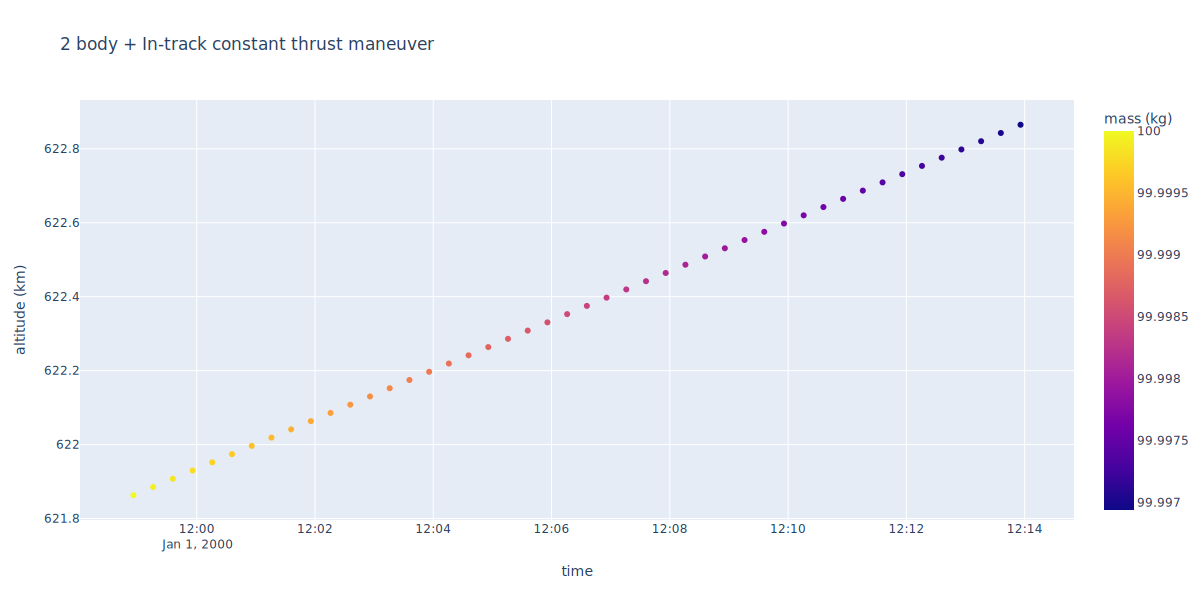

In [23]:
df = pd.DataFrame(data)
figure = px.scatter(
    data,
    x="time",
    y="altitude (km)",
    color="mass (kg)",
    title="2 body + In-track constant thrust maneuver",
    height=600,
    width=1200,
)
figure.show("svg")

---